In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn 

# Short Term Predictions Visualization(March - May all 3 years)

0
1
2


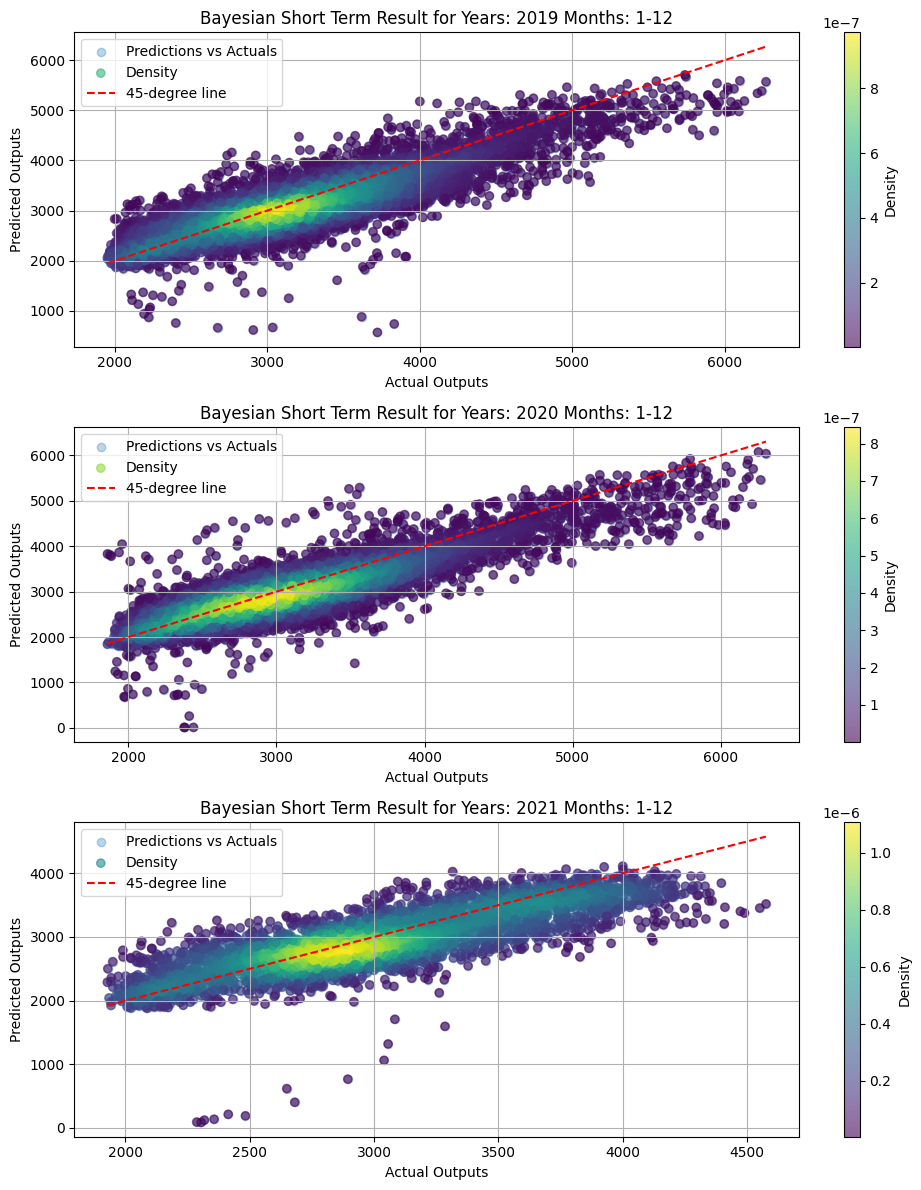

In [46]:
from scipy.stats import gaussian_kde
# Load the data into DataFrames
actuals_short = pd.read_csv("TestingShort/TestingActual_Short.csv")
predictions_short = pd.read_csv("TestingShort/TestingPredictionsShort.csv")
std_short = pd.read_csv("TestingShort/TestingStdShort.csv")
# Extract dates from the column headers
actuals_short.columns = pd.to_datetime(
    actuals_short.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)
predictions_short.columns = pd.to_datetime(
    predictions_short.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)
valid_months = [i for i in range(1,13,1)]
valid_years = [2019, 2020, 2021]
filtered_columns = [
    col for col in actuals_short.columns if col.month in valid_months and col.year in valid_years
]
filtered_actuals_short = actuals_short[filtered_columns]
filtered_predictions_short = predictions_short[filtered_columns]
def plot_monthly_comparison_with_density(actuals, predictions, months, years, figwidth = 10, figheight = 12, text = "Bayesian Long Term Result for Years:"):
    fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(figwidth, figheight))
    
    idx = 0 
    for year in years:
        print(idx)
        all_actuals = []
        all_predictions = []
    
        for month in months:
            # Filter columns for the specific month and year
            filtered_cols = [col for col in actuals.columns if col.month == month and col.year == year]
            monthly_actuals = actuals[filtered_cols].values.flatten()
            monthly_predictions = predictions[filtered_cols].values.flatten()
                
            # Remove NaN values
            mask = ~np.isnan(monthly_actuals) & ~np.isnan(monthly_predictions)
            monthly_actuals = monthly_actuals[mask]
            monthly_predictions = monthly_predictions[mask]
                
            # Accumulate data for the overall scatter plot
            all_actuals.extend(monthly_actuals)
            all_predictions.extend(monthly_predictions)
        
        all_actuals = np.array(all_actuals)
        all_predictions = np.array(all_predictions)
        
        # Create scatter plot
        scatter = axes[idx].scatter(all_actuals, all_predictions, alpha=0.3, label="Predictions vs Actuals")
        
        # Add density-based scatter plot if applicable
        if len(all_actuals) > 1 and len(all_predictions) > 1:
            xy = np.vstack([all_actuals, all_predictions])
            density = gaussian_kde(xy)(xy)
            scatter = axes[idx].scatter(all_actuals, all_predictions, c=density, cmap='viridis', alpha=0.6, label="Density")
            
            # Add a color bar for the density plot
            cbar = fig.colorbar(scatter, ax=axes[idx])
            cbar.set_label("Density")
        
        # Add a 45-degree line
        if len(all_actuals) > 0 and len(all_predictions) > 0:
            axes[idx].plot([all_actuals.min(), all_actuals.max()],
                           [all_actuals.min(), all_actuals.max()],
                           color='red', linestyle='--', label="45-degree line")
        
        # Labels and title
        axes[idx].set_xlabel("Actual Outputs")
        axes[idx].set_ylabel("Predicted Outputs")
        axes[idx].set_title("{} {} Months: {}-{}".format(text, year, months[0], months[-1]))
        axes[idx].legend()
        axes[idx].grid(True)
        
        idx += 1
    
    plt.tight_layout()
    plt.show()
# Generate combined plots for March, April, and May
plot_monthly_comparison_with_density(filtered_actuals_short, filtered_predictions_short, valid_months, [2019,2020,2021], text = "Bayesian Short Term Result for Years:" )

# Long Term Predictions Visualization(March - May all 3 years)

0


1


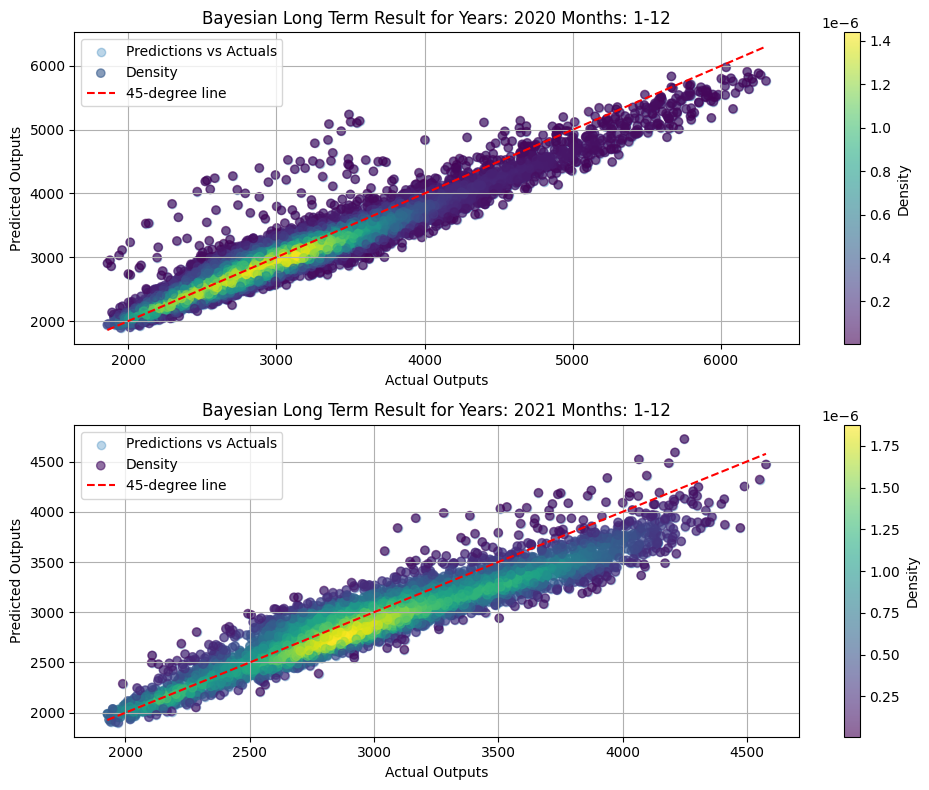

In [47]:
actuals_long = pd.read_csv("TestingLong/TestingActual_Long.csv")
predictions_long = pd.read_csv("TestingLong/TestingPredictionsLong.csv")
std_long = pd.read_csv("TestingLong/TestingStdLong.csv")
# Extract dates from the column headers
actuals_long.columns = pd.to_datetime(
    actuals_long.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)
predictions_long.columns = pd.to_datetime(
    predictions_long.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)

valid_months = [i for i in range(1,13)]
valid_years = [2020, 2021]
filtered_columns = [
    col for col in actuals_long.columns if col.month in valid_months and col.year in valid_years
]

filtered_actuals_long = actuals_long[filtered_columns]
filtered_predictions_long = predictions_long[filtered_columns]

filtered_columns = [
    col for col in actuals_long.columns if col.month in valid_months and col.year in valid_years
]

# Subset the data
filtered_actuals_long = actuals_long[filtered_columns]
filtered_predictions_long = predictions_long[filtered_columns]


plot_monthly_comparison_with_density(filtered_actuals_long, filtered_predictions_long, [i for i in range(1,13)], [2020,2021], figheight = 8, figwidth = 10, 
                                     text = "Bayesian Long Term Result for Years:")

# Boundary Encapsulation Viz:

In [48]:
import plotly.graph_objects as go
from scipy.stats import norm

def plot_time_series_with_confidence(
    actual_df, prediction_df, std_dev_df, start_col, end_col, confidence=0.95
):
    baseline_long = pd.read_csv("/home/jik19004/FilesToRun/BayesianTimeSeries/Bayesian_1sample/TestingLong/TestingPredictionsLong.csv")
    baseline_long.columns = pd.to_datetime(
    baseline_long.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)
    # Parse the start and end column names as datetime
    start_col = pd.to_datetime(start_col)
    end_col = pd.to_datetime(end_col)

    # Slice data based on the time range
    selected_actual = actual_df.loc[:, start_col:end_col]
    selected_prediction = prediction_df.loc[:, start_col:end_col]
    selected_std_dev = std_dev_df.loc[:, start_col:end_col]
    baseline_long = baseline_long.loc[:, start_col:end_col]

    # Calculate Z-score for the given confidence level
    Z = norm.ppf((1 + confidence) / 2)

    # Compute confidence interval bounds
    lower_bounds = selected_prediction - Z * selected_std_dev
    upper_bounds = selected_prediction + Z * selected_std_dev

    # Prepare x-axis labels
    time_range = selected_actual.columns

    # Create Plotly figure
    fig = go.Figure()

    # Add actual values
    fig.add_trace(
        go.Scatter(
            x=time_range,
            y=selected_actual.iloc[0],
            mode="lines",
            name="Actual Values",
            line=dict(color="orange"),
        )
    )

    # Add predictions
    fig.add_trace(
        go.Scatter(
            x=time_range,
            y=selected_prediction.iloc[0],
            mode="lines",
            name="Predicted Values",
            line=dict(color="green", dash = "dot"),
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=time_range,
            y=baseline_long.iloc[0],
            mode="lines",
            name="Baseline Prediction",
            line=dict(color='black', dash = "dot"),
            showlegend=True,
        )
    )
    

    # Add confidence interval bounds (shaded area)
    fig.add_trace(
        go.Scatter(
            x=time_range,
            y=upper_bounds.iloc[0],
            mode="lines",
            name="Upper Bound",
            line=dict(color='blue'),
            showlegend=True,
        )
    )


    
    fig.add_trace(
        go.Scatter(
            x=time_range,
            y=lower_bounds.iloc[0],
            mode="lines",
            name="Lower Bound",
            fill="tonexty",
            line=dict(color='red'),
            fillcolor='rgba(255, 211, 0, 0.1)',
            showlegend=True,
        )
    )

    # Update layout
    fig.update_layout(
        title="Energy Demand Forecast Demo",
        xaxis_title="Time",
        yaxis_title="Demand (MwH)",
        legend_title="Legend",
        template="plotly_white",
    )

    # Show the plot
    fig.show()

std_long.columns = predictions_long.columns.copy()
# Specify the range of columns to plot
start_column = pd.to_datetime("2020-10-10 00:00:00")
end_column = pd.to_datetime("2020-10-22 00:00:00")

# Call the function to plot
plot_time_series_with_confidence(actuals_long, predictions_long, std_long, start_column, end_column)

# Calculate the R^{2} coefficient for short and long term: 

In [49]:
print(valid_years)

[2020, 2021]


In [50]:
from sklearn.metrics import r2_score

normal_short = pd.read_csv("/home/jik19004/FilesToRun/BayesianTimeSeries/Bayesian_1sample/TestingShort/TestingPredictionsShort.csv")
normal_long = pd.read_csv("/home/jik19004/FilesToRun/BayesianTimeSeries/Bayesian_1sample/TestingLong/TestingPredictionsLong.csv")


normal_short.columns = pd.to_datetime(
    normal_short.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)
normal_long.columns = pd.to_datetime(
    normal_long.columns.str.extract(r'(\d{1,2}/\d{1,2}/\d{4})')[0], format='%m/%d/%Y', errors='coerce'
)

# Function to calculate R^2 for each month across the specified years
def calculate_r2(actuals, predictions, months, year):
    all_actuals = []
    all_predictions = []
    
    for month in months:
        # Filter data for the specific month and year
        filtered_cols = [col for col in actuals.columns if col.month == month and col.year == year]
        monthly_actuals = actuals[filtered_cols].values.flatten()
        monthly_predictions = predictions[filtered_cols].values.flatten()
        # Remove NaN values
        mask = ~np.isnan(monthly_actuals) & ~np.isnan(monthly_predictions)
        monthly_actuals = monthly_actuals[mask]
        monthly_predictions = monthly_predictions[mask]
        
        # Accumulate data for the overall calculation
        all_actuals.extend(monthly_actuals)
        all_predictions.extend(monthly_predictions)
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)
    return r2_score(all_actuals, all_predictions)
r2_scores = {}

short_years = [2019,2020,2021] 
months = [3,4,5]

for year in short_years: 
    r2_scores[year] = calculate_r2(filtered_actuals_short, normal_short, months, year) # calculate the r2 score for each year. 
# Display the R^2 scores for each month
print("Short Term R^2 coefficient:")
r2_scores

Short Term R^2 coefficient:


{2019: 0.5104278195081023, 2020: 0.45735252083425315, 2021: 0.5192926246143506}

In [51]:
r2_scores = {}
long_years = [2020,2021]
for year in long_years:
    r2_scores[year] = calculate_r2(filtered_actuals_long, normal_long, months, year)
# Display the R^2 scores for each month
print("Long Term R^2 coefficient:")
r2_scores

Long Term R^2 coefficient:


{2020: 0.0384645523868854, 2021: 0.47788008242383373}